### Finding bots from the pool of annotators




In [ ]:
import pandas as pd

df_raw = pd.read_csv('/content/nlp-challenge.csv')
df_raw

,Annotator ID,Text,Answer
0,A1MG8KNVSVZ365,@cz_binance Thanks for being upfront about thi...,True
1,A3OCJJMRKAIJZA,@cz_binance Thanks for being upfront about thi...,True
2,AQIP3DSYXEXX5,@cz_binance Thanks for being upfront about thi...,True
3,A1MG8KNVSVZ365,@cz_binance The speed with which Binance has r...,False
4,A3MV3PT4TOO69P,@cz_binance The speed with which Binance has r...,True
...,...,...,...
36412,A3BISMR4GI02ZG,@Hotbit_news @Alex_Hotbit Anyone here knows ho...,False
36413,A3MV3PT4TOO69P,@Hotbit_news @Alex_Hotbit Anyone here knows ho...,False
36414,A3MV3PT4TOO69P,"@etherdelta it's not the case with all dex, #B...",True
36415,A3OCJJMRKAIJZA,"@etherdelta it's not the case with all dex, #B...",True


In [ ]:
df_raw['Text'][3]

'@cz_binance The speed with which Binance has responded to their security incidentincluding public disclosureis impressive, and I admire the clarity of the message that they take responsibility and will make the users whole.'

In [14]:
counts = df_raw['Annotator ID'].value_counts().to_dict()
counts

{'A3MV3PT4TOO69P': 5126,
 'A3OCJJMRKAIJZA': 5001,
 'A3BISMR4GI02ZG': 3589,
 'A1MG8KNVSVZ365': 3561,
 'AQIP3DSYXEXX5': 3469,
 'A2LU259QPV1I4V': 2689,
 'A3BJX6UUSOIKFN': 1472,
 'A3BCKNE5CWHODZ': 1443,
 'A9HQ3E0F2AGVO': 1217,
 'ARW1TCHCLEK1W': 1042,
 'AR9AU5FY1S3RO': 990,
 'A1MJVTR0PCKBWW': 980,
 'AYTH0E5PUXWX8': 864,
 'A2GM5BW75YCKKW': 714,
 'AOOF0H0EIEFFQ': 565,
 'AMYURTQIMAC8T': 532,
 'A19X8IA9EKC3XH': 429,
 'A2WPHVMLLEV5ZB': 334,
 'AD1ILDUXZHASF': 267,
 'AG36U7IOG2LAP': 250,
 'A3124SRR191UIL': 205,
 'AGRYG65WJ1CKJ': 201,
 'A33B85TN97HQ33': 194,
 'A2R25RH05K0B68': 144,
 'A2CJFO19NY4T5R': 138,
 'A1M5BJTQIXCM33': 124,
 'A16184N1RO5OJV': 119,
 'A2A78DMGLC1S0Y': 100,
 'A33Y36Y252Z30U': 99,
 'A1YSYI926BBOHW': 84,
 'A2KHLJ2F58BEZK': 78,
 'A2HM35CWB7IIFM': 73,
 'A3HYCA7N5F6DL9': 67,
 'AJQGWGESKQT4Y': 45,
 'A1DP551UV06FN6': 39,
 'AC95JAUAM2L2Z': 35,
 'A1R0689JPSQ3OF': 31,
 'AKQAI78JTXXC9': 20,
 'AAX9LTAOIBECD': 18,
 'AXY0D2AMLKE2A': 17,
 'AKSLU0C30G3JT': 11,
 'A2R28HXAEFKBPC': 7,
 'A198H320N5M

# My naive approach of finding annotators:

In the comments section I have found one example solution (https://colab.research.google.com/drive/1wyLwzRbjzek4-Vg7iZuNxvMJ728caGLa?usp=sharing). This approach focused on how often annotators opinion on the comment differed from the other annotators. Basically, it was finding outliers. I also tried to solve the question without using NLP algorithms.

First, I will find the percentage of True and False answers, and then use Isolation Forest to get the outliers from the pool of annotators.

In [15]:
df_raw

,Annotator ID,Text,Answer
0,A1MG8KNVSVZ365,@cz_binance Thanks for being upfront about thi...,True
1,A3OCJJMRKAIJZA,@cz_binance Thanks for being upfront about thi...,True
2,AQIP3DSYXEXX5,@cz_binance Thanks for being upfront about thi...,True
3,A1MG8KNVSVZ365,@cz_binance The speed with which Binance has r...,False
4,A3MV3PT4TOO69P,@cz_binance The speed with which Binance has r...,True
...,...,...,...
36412,A3BISMR4GI02ZG,@Hotbit_news @Alex_Hotbit Anyone here knows ho...,False
36413,A3MV3PT4TOO69P,@Hotbit_news @Alex_Hotbit Anyone here knows ho...,False
36414,A3MV3PT4TOO69P,"@etherdelta it's not the case with all dex, #B...",True
36415,A3OCJJMRKAIJZA,"@etherdelta it's not the case with all dex, #B...",True


Let's calculate the percentage of True and False answers only taking annotators with 50+ annotations for outlier reduction and statistical significance.

In [16]:
def calculate_answer_percentage(df, annotator_id_col='Annotator ID', answer_col='Answer', min_annotations=50):
    # Calculate total number of answers for each annotator
    total_answers = df.groupby(annotator_id_col).size()

    # Calculate the percentage of True and False answers for each annotator
    answer_percentage = df.groupby([annotator_id_col, answer_col]).size().unstack(fill_value=0)
    answer_percentage = answer_percentage.div(total_answers, axis=0) * 100

    # Add the number of annotations made by each annotator to the DataFrame
    answer_percentage['Total Annotations'] = total_answers

    # Filter annotators with total annotations above the min_annotations threshold
    answer_percentage = answer_percentage[answer_percentage['Total Annotations'] > min_annotations]

    # Sort the DataFrame in descending order of the number of annotations
    answer_percentage = answer_percentage.sort_values(by='Total Annotations', ascending=False)

    return answer_percentage

# Calculate percentage of True and False answers and number of annotations for each annotator
annotator_answer_percentage = calculate_answer_percentage(df_raw, min_annotations=50)
print("Annotator Answer Percentage and Total Annotations (Annotations > 50):")
print(annotator_answer_percentage)

Annotator Answer Percentage and Total Annotations (Annotations > 50):
Answer              False       True  Total Annotations
Annotator ID                                           
A3MV3PT4TOO69P  40.050722  59.949278               5126
A3OCJJMRKAIJZA  28.254349  71.745651               5001
A3BISMR4GI02ZG  74.226804  25.773196               3589
A1MG8KNVSVZ365  45.717495  54.282505               3561
AQIP3DSYXEXX5   45.892188  54.107812               3469
A2LU259QPV1I4V  60.319821  39.680179               2689
A3BJX6UUSOIKFN   1.019022  98.980978               1472
A3BCKNE5CWHODZ  21.829522  78.170478               1443
A9HQ3E0F2AGVO   97.370583   2.629417               1217
ARW1TCHCLEK1W   42.706334  57.293666               1042
AR9AU5FY1S3RO   69.696970  30.303030                990
A1MJVTR0PCKBWW   5.918367  94.081633                980
AYTH0E5PUXWX8   70.717593  29.282407                864
A2GM5BW75YCKKW  35.434174  64.565826                714
AOOF0H0EIEFFQ    5.486726  94.5132

We have to reset the index:


In [17]:
df = pd.DataFrame(annotator_answer_percentage)
df.reset_index(inplace=True)
df.columns

Index(['Annotator ID', False, True, 'Total Annotations'], dtype='object', name='Answer')

In [18]:
df

Answer,Annotator ID,False,True,Total Annotations
0,A3MV3PT4TOO69P,40.050722,59.949278,5126
1,A3OCJJMRKAIJZA,28.254349,71.745651,5001
2,A3BISMR4GI02ZG,74.226804,25.773196,3589
3,A1MG8KNVSVZ365,45.717495,54.282505,3561
4,AQIP3DSYXEXX5,45.892188,54.107812,3469
5,A2LU259QPV1I4V,60.319821,39.680179,2689
6,A3BJX6UUSOIKFN,1.019022,98.980978,1472
7,A3BCKNE5CWHODZ,21.829522,78.170478,1443
8,A9HQ3E0F2AGVO,97.370583,2.629417,1217
9,ARW1TCHCLEK1W,42.706334,57.293666,1042


In [19]:
df.columns = df.columns.astype(str)


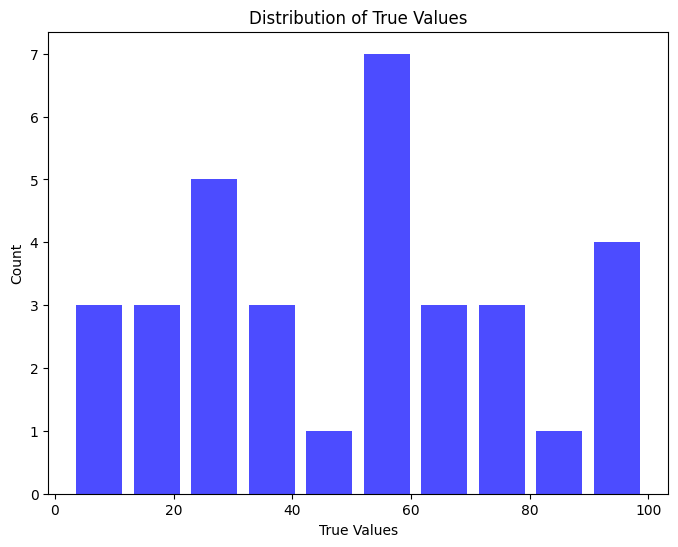

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(df['True'], bins=10, rwidth=0.8, color='blue', alpha=0.7)
plt.xlabel('True Values')
plt.ylabel('Count')
plt.title('Distribution of True Values')
plt.show()

In [21]:
from sklearn.ensemble import IsolationForest
model=IsolationForest(n_estimators=50, max_samples='auto', contamination='auto')
model.fit(df[['True']])

IsolationForest(n_estimators=50)

In [22]:
df['scores']=model.decision_function(df[['True']])
df['anomaly']=model.predict(df[['True']])
df.head(10)

Answer,Annotator ID,False,True,Total Annotations,scores,anomaly
0,A3MV3PT4TOO69P,40.050722,59.949278,5126,0.019880,1
1,A3OCJJMRKAIJZA,28.254349,71.745651,5001,-0.057695,-1
2,A3BISMR4GI02ZG,74.226804,25.773196,3589,0.008579,1
3,A1MG8KNVSVZ365,45.717495,54.282505,3561,0.072533,1
4,AQIP3DSYXEXX5,45.892188,54.107812,3469,0.073496,1
5,A2LU259QPV1I4V,60.319821,39.680179,2689,0.031721,1
6,A3BJX6UUSOIKFN,1.019022,98.980978,1472,-0.120138,-1
7,A3BCKNE5CWHODZ,21.829522,78.170478,1443,-0.025825,-1
8,A9HQ3E0F2AGVO,97.370583,2.629417,1217,-0.129795,-1
9,ARW1TCHCLEK1W,42.706334,57.293666,1042,0.057526,1


Let's detect the anomalies and suppose that they are bots:

In [23]:
anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)
print(anomaly)

Answer    Annotator ID      False       True  Total Annotations    scores  \
1       A3OCJJMRKAIJZA  28.254349  71.745651               5001 -0.057695   
6       A3BJX6UUSOIKFN   1.019022  98.980978               1472 -0.120138   
7       A3BCKNE5CWHODZ  21.829522  78.170478               1443 -0.025825   
8        A9HQ3E0F2AGVO  97.370583   2.629417               1217 -0.129795   
11      A1MJVTR0PCKBWW   5.918367  94.081633                980 -0.095466   
14       AOOF0H0EIEFFQ   5.486726  94.513274                565 -0.094124   
15       AMYURTQIMAC8T  84.398496  15.601504                532 -0.014763   
16      A19X8IA9EKC3XH   0.466200  99.533800                429 -0.135715   
23      A2R25RH05K0B68  20.833333  79.166667                144 -0.017589   
24      A2CJFO19NY4T5R  93.478261   6.521739                138 -0.082601   
27      A2A78DMGLC1S0Y  53.000000  47.000000                100 -0.009570   
28      A33Y36Y252Z30U  95.959596   4.040404                 99 -0.071584   

# So my assumption:
1       A3OCJJMRKAIJZA     
6       A3BJX6UUSOIKFN      
7       A3BCKNE5CWHODZ   
8        A9HQ3E0F2AGVO   
11      A1MJVTR0PCKBWW   
14       AOOF0H0EIEFFQ   
15       AMYURTQIMAC8T   
16      A19X8IA9EKC3XH
24      A2CJFO19NY4T5R   
25      A1M5BJTQIXCM33   
27      A2A78DMGLC1S0Y   
28      A33Y36Y252Z30U   
30      A2KHLJ2F58BEZK   
31      A2HM35CWB7IIFM   
#Further approach:
Probably best solution will be using pre-trained models on detecting bots from the pool of annotators.


In [24]:
df.loc[df['anomaly']==1]

Answer,Annotator ID,False,True,Total Annotations,scores,anomaly
0,A3MV3PT4TOO69P,40.050722,59.949278,5126,0.019880,1
2,A3BISMR4GI02ZG,74.226804,25.773196,3589,0.008579,1
3,A1MG8KNVSVZ365,45.717495,54.282505,3561,0.072533,1
4,AQIP3DSYXEXX5,45.892188,54.107812,3469,0.073496,1
5,A2LU259QPV1I4V,60.319821,39.680179,2689,0.031721,1
9,ARW1TCHCLEK1W,42.706334,57.293666,1042,0.057526,1
10,AR9AU5FY1S3RO,69.696970,30.303030,990,0.047275,1
12,AYTH0E5PUXWX8,70.717593,29.282407,864,0.019709,1
13,A2GM5BW75YCKKW,35.434174,64.565826,714,0.049875,1
17,A2WPHVMLLEV5ZB,60.479042,39.520958,334,0.037861,1
